**1. Data Import**

In [15]:
#필요한 라이브러리를 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 한글폰트 사용을 위한 라이브러리

#'Malgun Gothic' 폰트를 사용 설정합니다. (한글 표시 문제 해결)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

**2. encoding**

In [20]:
# CSV 파일 로드, 다양한 인코딩 시도
try:
    dataframe = pd.read_csv('netflix_titles.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        dataframe = pd.read_csv('netflix_titles.csv', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        dataframe = pd.read_csv('netflix_titles.csv', encoding='cp949')

FileNotFoundError: [Errno 2] No such file or directory: 'netflix_titles.csv'

**3. 데이터 전처리**

In [12]:
#불필요한 'Unnamed' 컬럼을 제거합니다.
dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]

#'director' 컬럼의 결측값을 'Unknown'으로 채웁니다.
dataframe['director'].fillna('Unknown', inplace=True)

#'date_added' 컬럼을 날짜 형식으로 변환합니다.
dataframe['date_added'] = pd.to_datetime(dataframe['date_added'], errors='coerce')

#'listed_in' 컬럼에서 장르 분리 후 explode를 통해 리스트를 풀어낸 후 다시 재구성합니다.
dataframe['listed_in'] = dataframe['listed_in'].str.split(', ')
dataframe = dataframe.explode('listed_in')

#'International Movies'와 'International TV Shows' 범주를 제거합니다.
dataframe_filtered = dataframe[~dataframe['listed_in'].isin(['International Movies', 'International TV Shows'])]

#연도별로 각 장르의 빈도를 계산하여 정리합니다.
genre_by_year_filtered = dataframe_filtered.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)


**4. 시각화 후 데이터 전처리 수정 과정**

'''
 Scatter plot에서 2020~2024년 특정 연도의 데이터가 보이지 않는 문제

 1. 데이터셋에 그 연도의 데이터가 존재하지 않거나,
 2. 데이터 처리 과정에서 제외
 3. 데이터셋을 확인
 4. 필요한 경우 데이터를 추가 또는 범위를 조정하는 작업이 필요

 먼저, 데이터셋에 2024년까지의 데이터가 있는지 확인
 이를 위해 release_year 열의 최대값을 확인하고, 해당 연도까지의 데이터가 존재하는지 검사


 '''

In [3]:
# release_year 컬럼의 최소값과 최대값을 확인
release_year_range = dataframe_filtered['release_year'].agg(['min', 'max'])
release_year_range
print(release_year_range)


NameError: name 'dataframe_filtered' is not defined

'''
 2024년 데이터는 몇몇 장르에서만 매우 낮은 빈도수(예: 1)를 가지고 있는 것으로 확인.

 이러한 낮은 빈도수는 scatter plot에서 해당 연도의 데이터가 상대적으로 작게 표시되거나 전혀 표시되지 않게 만들 수 있음

 이 문제를 해결하기 위해, 데이터 시각화 시 장르의 빈도가 너무 낮은 경우 이를 더 잘 보이게 만드는 방법을 적용

 예를 들어, 빈도의 최소 크기를 설정하여 모든 데이터 포인트가 시각화에서 일정 크기 이상으로 보이도록 할 수 있음.

 다음은 수정된 scatter plot 코드로, sizes 파라미터를 조정하여 모든 데이터 포인트가 최소한 일정 크기 이상으로 표시

'''

In [14]:
# 2024년 데이터의 장르 분포를 확인
genre_distribution_2024 = genre_by_year_filtered.loc[2024].sort_values(ascending=False)
print(genre_distribution_2024.head())  # 상위 몇 개 장르를 출력하여 확인

# 각 연도별 가장 인기 있는 장르와 그 빈도수 계산
max_genre_per_year = genre_by_year_filtered.idxmax(axis=1)
max_counts_per_year = genre_by_year_filtered.max(axis=1)

# 인기 장르와 해당 빈도수를 데이터프레임으로 결합
popular_genre_by_year = pd.DataFrame({
    'Year': max_genre_per_year.index,
    'Genre': max_genre_per_year.values,
    'Count': max_counts_per_year.values
})

#필요한 데이터만 선택
dataframe_s = dataframe[['release_year', 'type', 'listed_in']]

#'listed_in' 컬럼이 이미 리스트 형태로 데이터가 주어져 있으므로, 그대로 확장
genres_expanded = dataframe_s.explode('listed_in')

#'listed_in' 컬럼명을 'listed_genres'로 변경
genres_expanded.rename(columns={'listed_in': 'listed_genres'}, inplace=True)

#출시년도와 장르별 작품 수 집계
grouped = genres_expanded.groupby(['release_year', 'listed_genres']).size().reset_index(name='count')

#장르별 총 출현 빈도 계산
genre_counts = genres_expanded['listed_genres'].value_counts()

#Top 10 장르 식별
top_10_genres = genre_counts.head(10).index.tolist()

listed_in
Action                          1
Sci-fi                          1
Horror                          1
Stand-Up Comedy & Talk Shows    0
Romantic Movies                 0
Name: 2024, dtype: int64


**연도를 범위로 설정**

In [15]:
# plt.figure(figsize=(14, 8))
# sns.scatterplot(data=popular_genre_by_year, x='Year', y='Genre', size='Count', sizes=(100, 400), legend=None)
# plt.title('연도별 가장 인기 있는 넷플릭스 장르')
# plt.xlabel('연도')
# plt.ylabel('장르')
# plt.grid(True)
# plt.xlim(1960, 2024)  # X축의 시작과 끝 연도를 설정
# plt.show()

**필터링으로 연도를 설정**

In [ ]:

# filtered_data = popular_genre_by_year[popular_genre_by_year['Year'] >= 1960]
# plt.figure(figsize=(14, 8))
# sns.scatterplot(data=filtered_data, x='Year', y='Genre', size='Count', sizes=(100, 400), legend=None)
# plt.title('1960년 이후 연도별 가장 인기 있는 넷플릭스 장르')
# plt.xlabel('연도')
# plt.ylabel('장르')
# plt.grid(True)
# plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


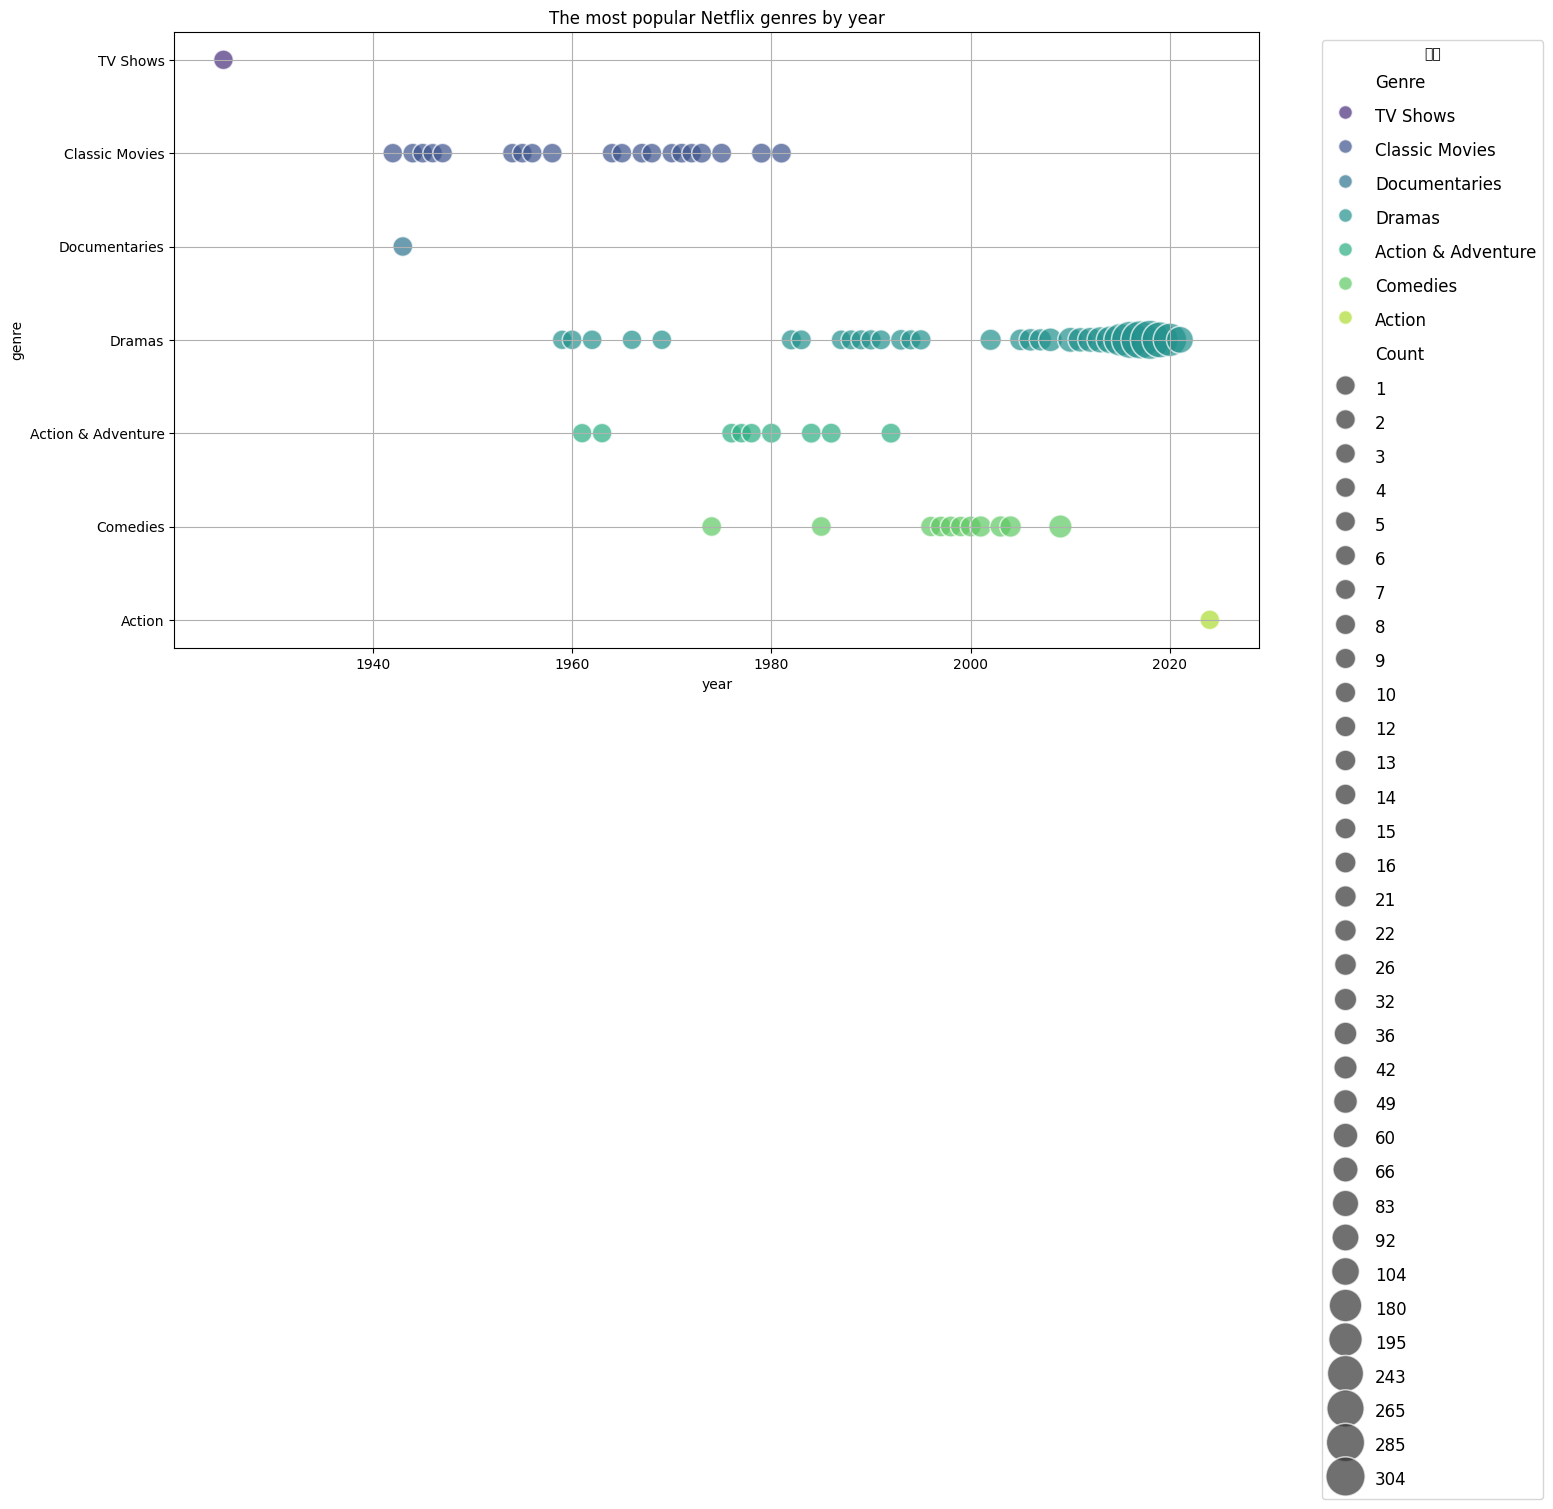

In [16]:
plt.figure(figsize=(14, 8))
# scatterplot 생성, 's' 파라미터로 마커의 크기를 직접 설정할 수 있습니다.
scatter = sns.scatterplot(data=popular_genre_by_year, x='Year', y='Genre', hue='Genre', size='Count', sizes=(200, 800), alpha=0.7, legend='full', palette='viridis', s=100)

# 범례 설정을 조정합니다. 범례 아이콘 크기를 조절하려면 handlelength와 handleheight를 조정해야 합니다.
plt.legend(title='장르', bbox_to_anchor=(1.05, 1), loc=2, prop={'size': 12}, handlelength=2, handleheight=2)

plt.title('The most popular Netflix genres by year')
plt.xlabel('year')
plt.ylabel('genre')
plt.grid(True)
plt.show()


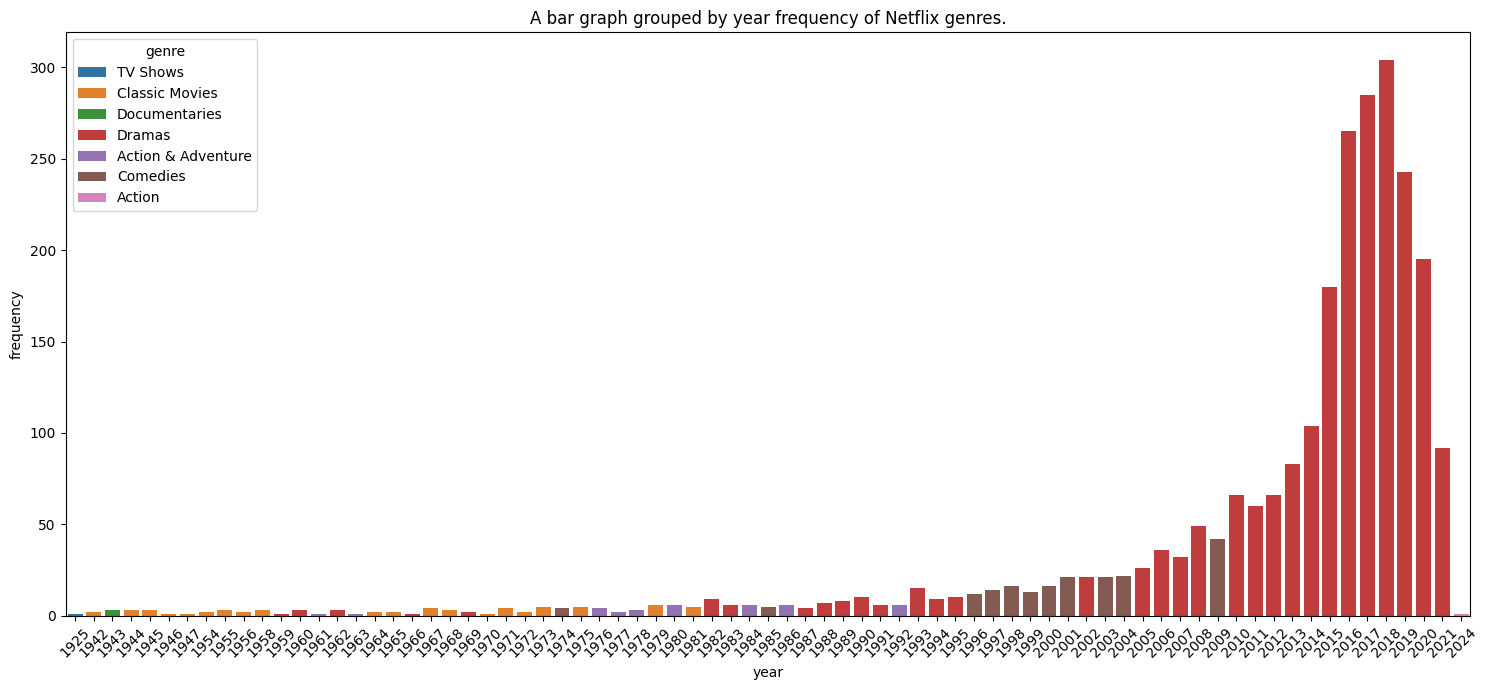

In [18]:
# 연도별로 각 장르의 빈도를 비교하기 위한 그룹화된 막대 그래프
plt.figure(figsize=(15, 7))
sns.barplot(x='Year', y='Count', hue='Genre', data=popular_genre_by_year)
plt.title('A bar graph grouped by year frequency of Netflix genres.')
plt.xlabel('year')
plt.ylabel('frequency')
plt.legend(title='genre')
plt.xticks(rotation=45)  # 연도 라벨이 겹치지 않도록 회전
plt.tight_layout()  # 레이아웃 설정으로 그래프가 잘리지 않게 조정
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

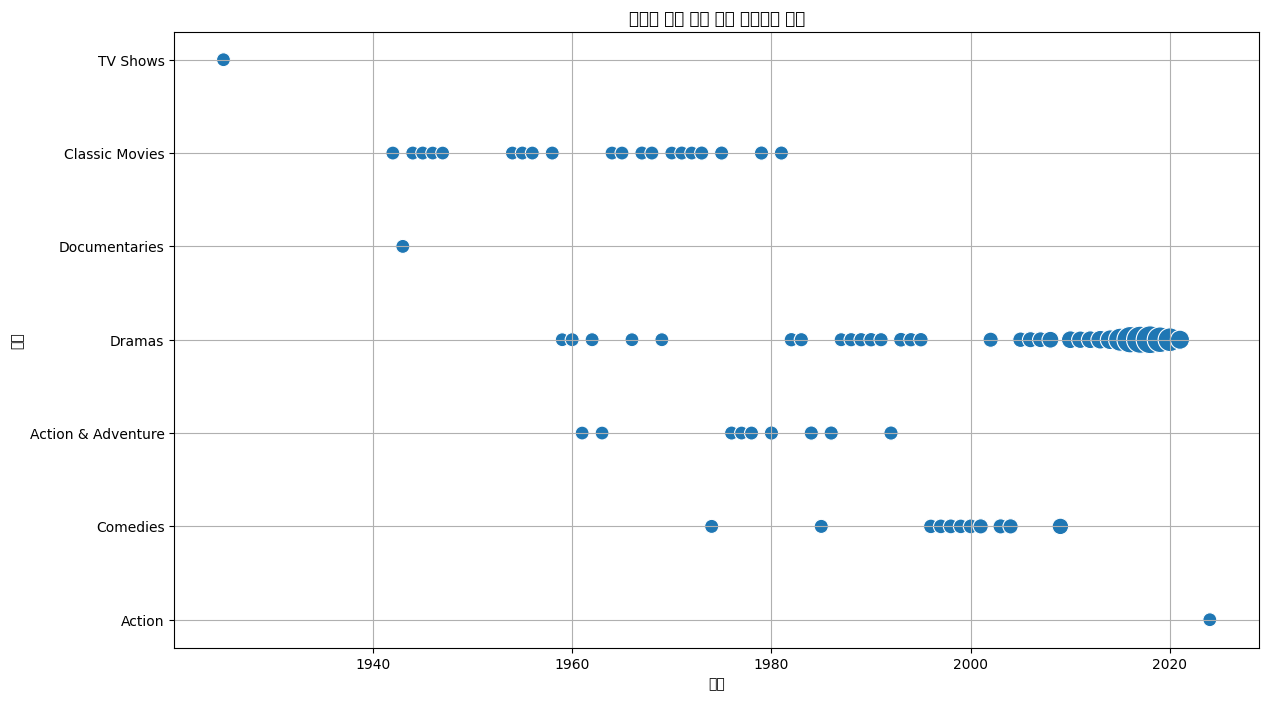

In [17]:
# Scatterplot
# 점의 크기를 'Count'에 따라 조정하여 모든 점은 최소 100에서 최대 400의 크기를 가짐
plt.figure(figsize=(14, 8))
sns.scatterplot(data=popular_genre_by_year, x='Year', y='Genre', size='Count', sizes=(100, 400), legend=None)
plt.title('연도별 가장 인기 있는 넷플릭스 장르') # 연도별 가장 인기 있는 넷플릭스 장르
plt.xlabel('연도') # 연도
plt.ylabel('장르') # 장르
plt.grid(True)
plt.show()

**Heatmap**


연도별 장르 빈도를 히트맵으로 시각화

X축 눈금 조정: 10년 간격으로 표시

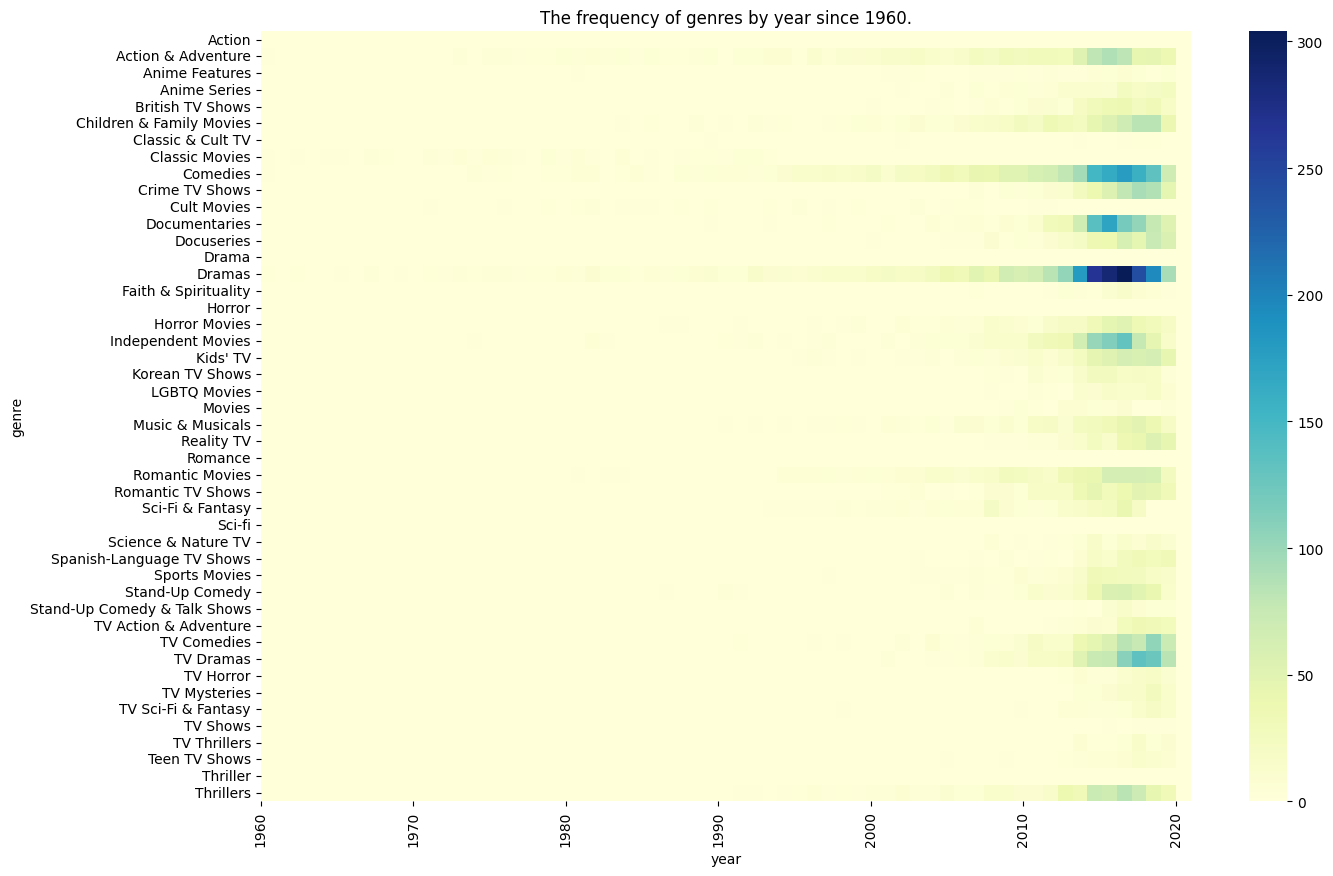

In [19]:
# 1960년 이후 데이터만 필터링하여 새 DataFrame 생성
filtered_genre_by_year = genre_by_year_filtered.loc[1960:]

# X축 눈금 조정을 위한 설정
# 1960년부터 최대 연도까지 10년 간격
xticks = np.arange(1960, filtered_genre_by_year.index.max() + 1, 10)
# 눈금 레이블을 문자열 리스트로 변환
xticklabels = list(map(str, xticks))

plt.figure(figsize=(15, 10))
sns.heatmap(filtered_genre_by_year.T, cmap="YlGnBu", xticklabels=xticklabels)
# 실제 눈금 위치 지정
plt.xticks(np.linspace(0, len(filtered_genre_by_year.index)-1, len(xticks)), xticklabels)
plt.title('The frequency of genres by year since 1960.') # 1960년 이후 연도별 장르 빈도 Heatmap
plt.xlabel('year')
plt.ylabel('genre')
plt.show()

**Bar Plot**

최근 연도의 가장 인기 있는 장르를 막대 그래프로 시각화

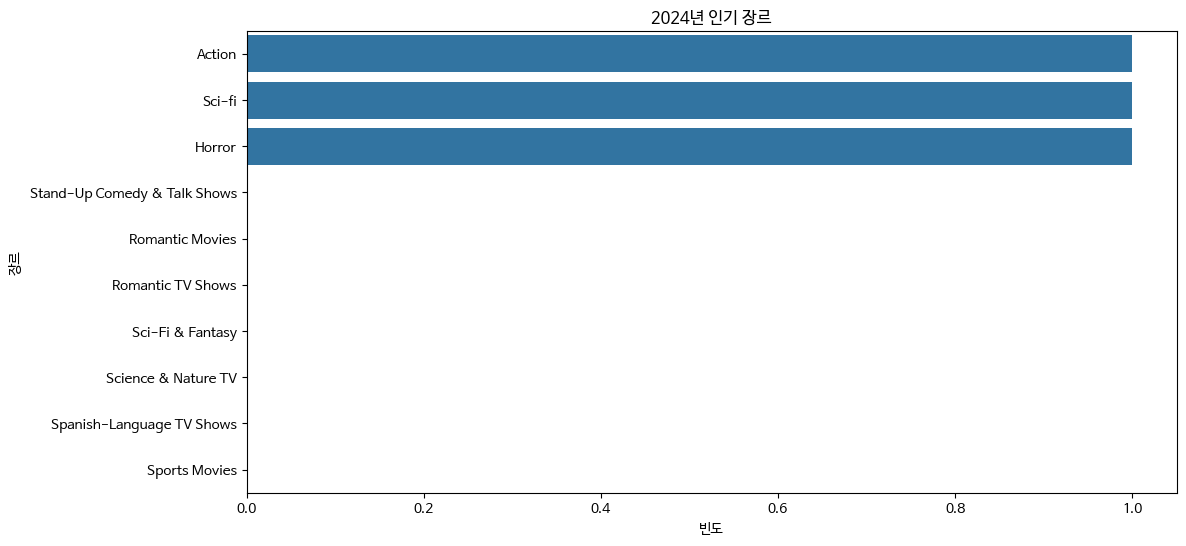

In [ ]:
# 2024년 자료만
recent_year = genre_by_year_filtered.index.max()
recent_genre_popularity = genre_by_year_filtered.loc[recent_year].sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=recent_genre_popularity.values, y=recent_genre_popularity.index)
plt.title(f'{recent_year}Popular genre')
plt.xlabel('frequency')
plt.ylabel('genre')
plt.show()

In [ ]:
#Scatter 그래프 그리기
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('tab20', 10)  # 칼라풀한 색상 10개 준비

for i, genre in enumerate(grouped['listed_genres'].unique()):
    group = grouped[grouped['listed_genres'] == genre]
    if genre in top_10_genres:
        color = colors(top_10_genres.index(genre))
    else:
        color = 'grey'  # 나머지 장르는 회색으로
    ax.scatter(group['release_year'], group['count'], label=genre, color=color)

ax.set_xlabel('Release Year')
ax.set_ylabel('Number of Titles')
ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()